In [1]:
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt
from visualize import *
from calibration import *
import torch
import GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import normalize
numpy.random.seed(0x5eed)
import warnings
warnings.filterwarnings("ignore")
% matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 6
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
import os
from PIL import Image, ImageStat
METHOD_NAME = "brightness_gpc"

In [2]:
# https://stackoverflow.com/questions/3490727/what-are-some-methods-to-analyze-image-brightness-using-python
def comp_brightness( im_file ):
    im = Image.open(im_file).convert('L')
    stat = ImageStat.Stat(im)
    return stat.mean[0]

In [3]:
with open("data/predictions.txt") as f:
    model_output = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
model_output = [x.split(" ") for x in model_output][1:] 

Y_true = np.array([_[1] for _ in model_output])
Y_predict = np.array([_[2] for _ in model_output])
confidence = np.array([_[3] for _ in model_output])
NUM_IMG = confidence.shape[0]

LIST_IMG_NAMES = ["data/img/" + str(i) + ".png" for i in range(NUM_IMG)]
brightness = np.array([comp_brightness(f) for f in LIST_IMG_NAMES])

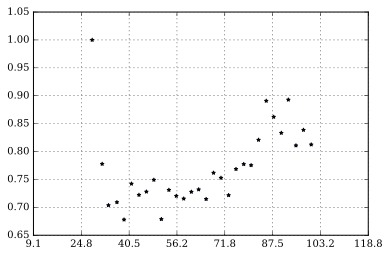

In [4]:
fig, ax = plt.subplots()
ax = brightness_plot_binary(ax, brightness, Y_predict, Y_true, num_bins=30)

In [14]:
def gpc_sklearn(ax, x, y, kernel, optimizer="fmin_l_bfgs_b"):
    # Fit GaussianProcessClassification and LinearRegression models
    gpc = GaussianProcessClassifier(kernel=kernel, optimizer=optimizer)
    gpc.fit(x[:, np.newaxis], y)
    y_ = gpc.predict_proba(x[:, np.newaxis])[:,1]
    xs = np.linspace(np.min(x), np.max(x), 1000)
    ys = gpc.predict_proba(xs[:, np.newaxis])[:,1]
    ax.plot(xs, ys, markersize=12, alpha = 0.2)
    # compute ece and acc after calibration
    ece = EceEval(np.array([1-y_, y_]).T , y, num_bins = 100)
    y_predict = y_ > 0.5
    acc = (y_predict == y).mean()
#     ax.text(x.min(), 0.9, 'ECE=%.4f\nACC=%.4f'% (ece, acc), size=8, ha='left', va='center',
#             bbox={'facecolor':'green', 'alpha':0.5, 'pad':4})
    ax.set_ylim(0.0, 1.0)
    ax.set_xticks([])
    return ax, ece, acc

def RbfGridSearch(brightness, Y_true, Y_predicted, N):
    RBF_SCALES = [1,10,20,50,100]
    #RBF_SCALE = 0.5
    for RBF_SCALE in RBF_SCALES:
        KERNELS = [None,
                   1 ** 2 * RBF(RBF_SCALE, (0.05, 1)), 
                   1 ** 2 * RBF(RBF_SCALE, (0.05, 1)) + WhiteKernel(noise_level = 1.0),]
        f, ax = plt.subplots(1, 3, sharex='col', sharey='row')
        f.set_figheight(2)
        f.set_figwidth(8)
        L = len(KERNELS)
        for i in range(L):
            kernel = KERNELS[i]
            ax[i], ece, acc = gpc_sklearn(ax[i],
                                brightness[:N],
                                np.array([Y_true[_] == Y_predict[_] for _ in range(N)]),
                                kernel,
                                optimizer=None)
            ax[i] = brightness_plot_binary(ax[i], brightness[:N], Y_predict[:N], Y_true[:N], num_bins=N/50)
            ax[i].set_xlabel("ECE=%.4f, ACC=%.4f"% (ece, acc), fontsize = 10)
            ax[i].set_ylabel("Accuracy") 
        f.tight_layout()
        
        f, ax = plt.subplots(1, 3, sharex='col', sharey='row')
        f.set_figheight(2)
        f.set_figwidth(8)
        for i in range(L):
            kernel = KERNELS[i]
            ax[i], ece, acc = gpc_sklearn(ax[i],
                                brightness[:N],
                                np.array([Y_true[_] == Y_predict[_] for _ in range(N)]),
                                kernel)
            ax[i] = brightness_plot_binary(ax[i], brightness[:N], Y_predict[:N], Y_true[:N], num_bins=N/50)
            ax[i].set_xlabel("ECE=%.4f, ACC=%.4f"% (ece, acc), fontsize = 10)
            ax[i].set_ylabel("Accuracy") 
        f.tight_layout()

CPU times: user 14min 57s, sys: 1h 9min 30s, total: 1h 24min 27s
Wall time: 2min 42s


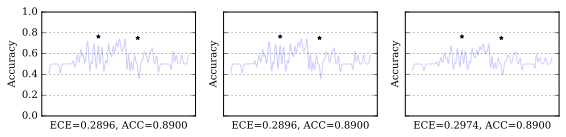

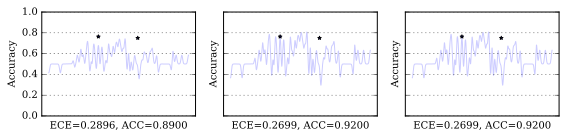

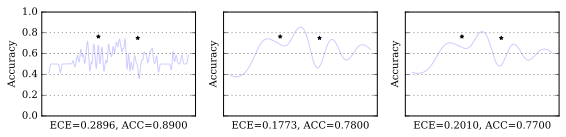

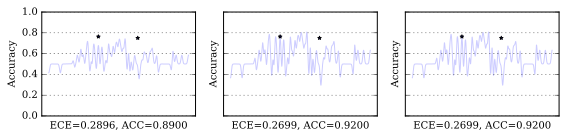

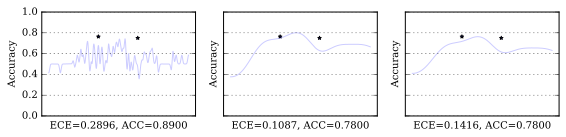

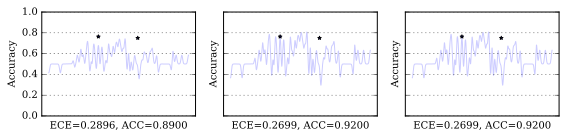

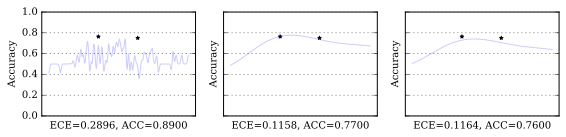

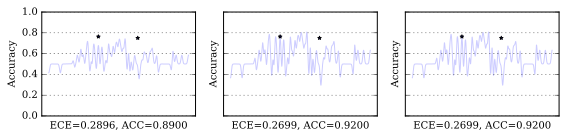

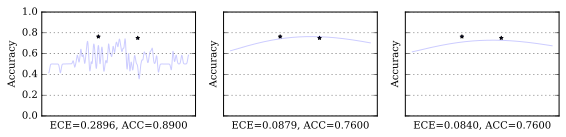

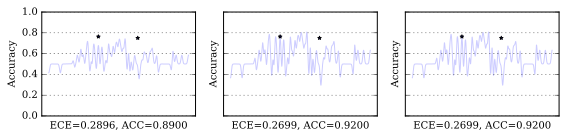

In [15]:
%%time
# GPC with sklearn
N = 100
RbfGridSearch(brightness, Y_true, Y_predict, N)

CPU times: user 1h 24min 39s, sys: 5h 39min 4s, total: 7h 3min 44s
Wall time: 13min 52s


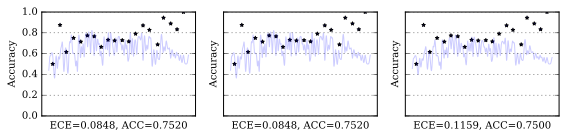

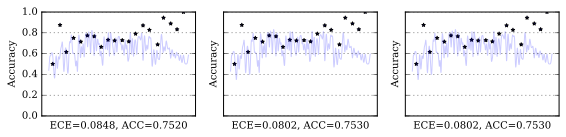

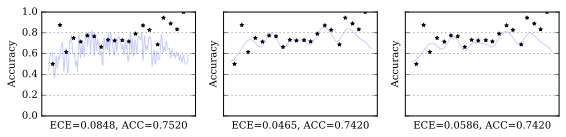

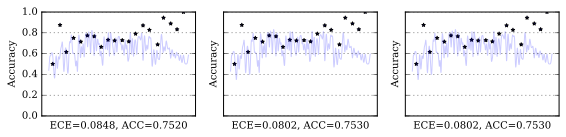

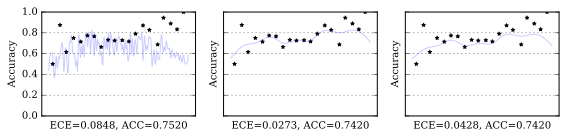

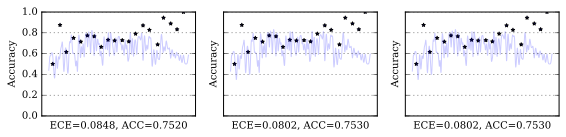

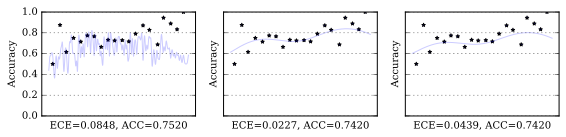

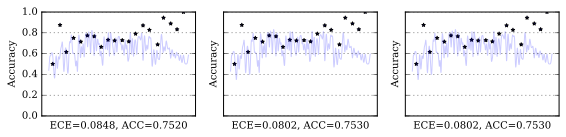

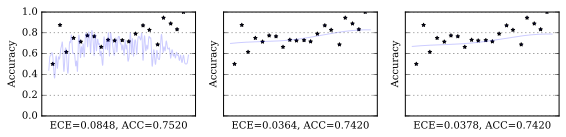

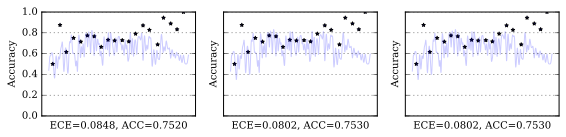

In [16]:
%%time
# GPC with sklearn
N = 1000
RbfGridSearch(brightness, Y_true, Y_predict, N)

In [ ]:
%%time
# GPC with sklearn
N = 2000
RbfGridSearch(brightness, Y_true, Y_predict, N)

In [ ]:
%%time
# GPC with sklearn
N = 5000
RbfGridSearch(brightness, Y_true, Y_predict, N)

In [ ]:
%%time
# GPC with sklearn
N = 10000
RbfGridSearch(brightness, Y_true, Y_predict, N)